In [1]:
#This project formulates the task of Florida manatee conservation as a POMDP problem.

In [2]:
#Libraries and Packages
using POMDPs
using POMDPModelTools
using QuickPOMDPs
using POMDPTools
using QMDP
using BasicPOMCP
using D3Trees
using POMDPModels
using POMDPSimulators
using FIB
using Plots

In [3]:
#POMDP Formulation

@enum State extinct endangered threatened
@enum Action do_nothing survey rescue rehabilitate 
@enum Observation seen_nothing wild_carcass wild_living

pomdp = QuickPOMDP(
    states       = [extinct, endangered, threatened],  # 𝒮
    actions      = [do_nothing, survey, rescue, rehabilitate],  # 𝒜
    observations = [seen_nothing, wild_carcass, wild_living], # 𝒪
    initialstate = [threatened],          # Deterministic initial state
    discount     = 0.9,             # γ

    transition = function T(s, a)
        if s == extinct
            return SparseCat([extinct, endangered, threatened], [1, 0, 0])
        elseif s == endangered && a == do_nothing
            return SparseCat([extinct, endangered, threatened], [0.2, 08, 0])
        elseif s == endangered && a == survey
            return SparseCat([extinct, endangered, threatened], [0.2, 0.8, 0])
        elseif s == endangered && a == rescue
            return SparseCat([extinct, endangered, threatened], [0.01, 0.49, 0.5])
        elseif s == endangered && a == rehabilitate
            return SparseCat([extinct, endangered, threatened], [0.01, 0.59, 0.4])
        elseif s == threatened && a == do_nothing
            return SparseCat([extinct, endangered, threatened], [0, 0.25, 0.75])
        elseif s == threatened && a == survey
            return SparseCat([extinct, endangered, threatened], [0, 0.25, 0.75])
        elseif s == threatened && a == rescue
            return SparseCat([extinct, endangered, threatened], [0, 0.15, 0.85])
        elseif s == threatened && a == rehabilitate
            return SparseCat([extinct, endangered, threatened], [0, 0.05, 0.95])
        end
    end,

    observation = function O(s, a, s′)
        if s′ == extinct
            return SparseCat([seen_nothing, wild_carcass, wild_living], [1, 0, 0])
        elseif s′ == endangered && a == do_nothing
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.99, 0.01, 0])
        elseif s′ == endangered && a == survey
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0, 0.9, 0.1])
        elseif s′ == endangered && a == rescue
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.9, 0.1, 0])
        elseif s′ == endangered && a == rehabilitate
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.99, 0.01, 0])
        elseif s′ == threatened && a == do_nothing
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.99, 0, 0.01])
        elseif s′ == threatened && a == survey
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0, 0.1, 0.9])
        elseif s′ == threatened && a == rescue
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.9, 0, 0.1])
        elseif s′ == threatened && a == rehabilitate
            return SparseCat([seen_nothing, wild_carcass, wild_living], [0.99, 0, 0.01])
        end
    end,

    reward = function R(s, a)
        if s == extinct && a == do_nothing
            return -201
        elseif s == extinct && a == survey
            return -210
        elseif s == extinct && a == rescue
            return -270
        elseif s == extinct && a == rehabilitate
            return -270
        elseif s == endangered && a == do_nothing
            return -101
        elseif s == endangered && a == survey
            return -110
        elseif s == endangered && a == rescue
            return -170
        elseif s == endangered && a == rehabilitate
            return -170
        elseif s == threatened && a == do_nothing
            return -1
        elseif s == threatened && a == survey
            return -10
        elseif s == threatened && a == rescue
            return -70
        elseif s == threatened && a == rehabilitate
            return -70
        end
    end,
)

QuickPOMDP{UUID("4284e4cf-eb46-4ceb-ac45-06568ce5285a"), State, Action, Observation, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{State, Int64}, Bool, Dict{Observation, Int64}, Vector{State}, Vector{Observation}, Float64, Vector{Action}, typeof(O), Dict{Action, Int64}, Vector{State}, typeof(T), typeof(R)}}}((stateindex = Dict{State, Int64}(endangered => 2, extinct => 1, threatened => 3), isterminal = false, obsindex = Dict{Observation, Int64}(wild_carcass => 2, seen_nothing => 1, wild_living => 3), states = State[extinct, endangered, threatened], observations = Observation[seen_nothing, wild_carcass, wild_living], discount = 0.9, actions = Action[do_nothing, survey, rescue, rehabilitate], observation = O, actionindex = Dict{Action, Int64}(rescue => 3, survey => 2, do_nothing => 1, rehabilitate => 4), initialstate = State[threatened], transition = T, reward = R))

In [4]:
# Experimenting with Belief Updater as a Bayesian filter 

updater(pomdp::QuickPOMDP) = DiscreteUpdater(pomdp);
b0 = uniform_belief(pomdp); b0.b

for i in 0:10
    observation_choices = [seen_nothing, wild_carcass, wild_living]
    o1 = rand(observation_choices)
    a1 = rehabilitate
    o1 = seen_nothing
    b1 = update(updater(pomdp), b0, a1, o1)
    b1.b
end

In [5]:
# Solve POMDP using QMDP Offline Method
qmdp_solver = QMDPSolver(max_iterations = 100)
qmdp_policy = solve(qmdp_solver, pomdp)

AlphaVectorPolicy{QuickPOMDP{UUID("4284e4cf-eb46-4ceb-ac45-06568ce5285a"), State, Action, Observation, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{State, Int64}, Bool, Dict{Observation, Int64}, Vector{State}, Vector{Observation}, Float64, Vector{Action}, typeof(O), Dict{Action, Int64}, Vector{State}, typeof(T), typeof(R)}}}, Action}(QuickPOMDP{UUID("4284e4cf-eb46-4ceb-ac45-06568ce5285a"), State, Action, Observation, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{State, Int64}, Bool, Dict{Observation, Int64}, Vector{State}, Vector{Observation}, Float64, Vector{Action}, typeof(O), Dict{Action, Int64}, Vector{State}, typeof(T), typeof(R)}}}((stateindex = Dict{State, Int64}(endangered => 2, extinct => 1, threatened => 3), isterminal = false, o

In [6]:
# Check action that QMDP policy takes for various belief states
for i in 0:10 
    # Inner For-loop
    for j in 0:10-i 
        b = [i/10, j/10, (10-i-j)/10]
        a = action(qmdp_policy, b)
        if i <= j || 10-i-j <= j
            println(b,a)
        end
    end
end

[0.0, 0.0, 1.0]do_nothing
[0.0, 0.1, 0.9]rehabilitate
[0.0, 0.2, 0.8]rehabilitate
[0.0, 0.3, 0.7]rehabilitate
[0.0, 0.4, 0.6]rehabilitate
[0.0, 0.5, 0.5]rehabilitate
[0.0, 0.6, 0.4]rescue
[0.0, 0.7, 0.3]rescue
[0.0, 0.8, 0.2]rescue
[0.0, 0.9, 0.1]rescue
[0.0, 1.0, 0.0]rescue
[0.1, 0.1, 0.8]rehabilitate
[0.1, 0.2, 0.7]rehabilitate
[0.1, 0.3, 0.6]rehabilitate
[0.1, 0.4, 0.5]rehabilitate
[0.1, 0.5, 0.4]rescue
[0.1, 0.6, 0.3]rescue
[0.1, 0.7, 0.2]rescue
[0.1, 0.8, 0.1]rescue
[0.1, 0.9, 0.0]rescue
[0.2, 0.2, 0.6]rehabilitate
[0.2, 0.3, 0.5]rehabilitate
[0.2, 0.4, 0.4]rehabilitate
[0.2, 0.5, 0.3]rescue
[0.2, 0.6, 0.2]rescue
[0.2, 0.7, 0.1]rescue
[0.2, 0.8, 0.0]rescue
[0.3, 0.3, 0.4]rehabilitate
[0.3, 0.4, 0.3]rescue
[0.3, 0.5, 0.2]rescue
[0.3, 0.6, 0.1]rescue
[0.3, 0.7, 0.0]rescue
[0.4, 0.3, 0.3]rehabilitate
[0.4, 0.4, 0.2]rescue
[0.4, 0.5, 0.1]rescue
[0.4, 0.6, 0.0]rescue
[0.5, 0.3, 0.2]rescue
[0.5, 0.4, 0.1]rescue
[0.5, 0.5, 0.0]rescue
[0.6, 0.2, 0.2]rehabilitate
[0.6, 0.3, 0.1]rescue
[0.6

[[-2009.9466115882362, -6702.765784016392, -533.1502974218058], [-2018.9466115882362, -1023.0679294789336, -542.1502974218058], [-2078.946611588236, -765.6642411568769, -581.2239614725547], [-2078.946611588236, -786.5904878261404, -560.2976255233035]]

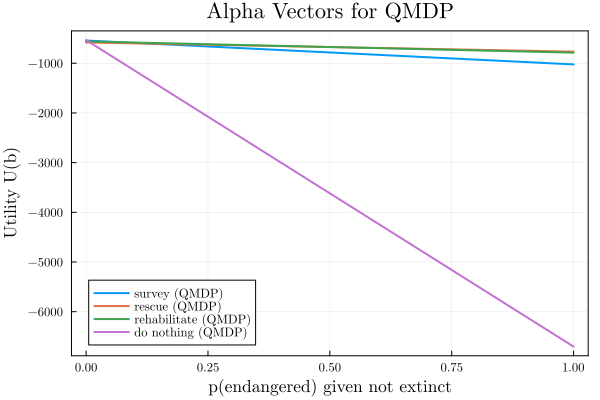

In [7]:
begin
	# Alpha Vectors for QMDP, where extinct belief is 0
	
	default(fontfamily="Computer Modern", framestyle=:box) 
	p_extinct = 0
	
	#print(alphavectors(qmdp_policy))

	alpha_do_nothing = alphavectors(qmdp_policy)[1]
	alpha_survey = alphavectors(qmdp_policy)[2]
	alpha_rescue = alphavectors(qmdp_policy)[3]
	alpha_rehabilitate = alphavectors(qmdp_policy)[4]
	print(alphavectors(qmdp_policy))
	x = range(0, 1, length=100)
	y1= @.  (alpha_do_nothing[2]-alpha_do_nothing[3]) * x + alpha_do_nothing[3]
	y2 = @. (alpha_survey[2]-alpha_survey[3]) *x + alpha_survey[3]
	y3= @.  (alpha_rescue[2]-alpha_rescue[3]) * x + alpha_rescue[3]
	y4 = @. (alpha_rehabilitate[2]-alpha_rehabilitate[3]) *x + alpha_rehabilitate[3]
	

    plot1 = plot(x, [y2 y3 y4 y1], title="Alpha Vectors for QMDP", xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)", label=["survey (QMDP)" "rescue (QMDP)" "rehabilitate (QMDP)" "do nothing (QMDP)"], linewidth=2)
    #action(qmdp_policy, [1-p_endangered - p_threatened,p_endangered, p_threatened])
	#plot_alpha_vectors(qmdp_policy, p_hungry)
end

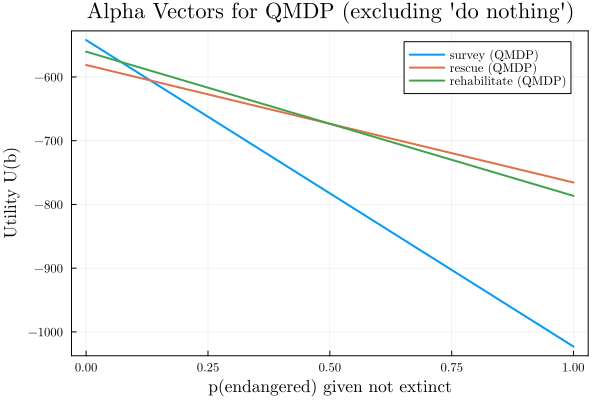

In [8]:
#Simplify Plot



plot2 = plot(x, [y2 y3 y4], 
  title="Alpha Vectors for QMDP (excluding 'do nothing')", 
    xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)",
    label=["survey (QMDP)" "rescue (QMDP)" "rehabilitate (QMDP)"], linewidth=2)
        
        

In [9]:


# ymax = @. max([y1,y2,y3,y4])
# plot(x, [y2 y3 y4], 
#   title="Alpha Vectors", 
#     label=["survey (QMDP)" "rescue (QMDP)" "rehabilitate (QMDP)"], linewidth=2)

In [10]:
#Solve POMDP using fast informed bound (FIB) Offline Method

fib_solver = FIBSolver(max_iterations=100)
fib_policy = solve(fib_solver, pomdp)

AlphaVectorPolicy{QuickPOMDP{UUID("4284e4cf-eb46-4ceb-ac45-06568ce5285a"), State, Action, Observation, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{State, Int64}, Bool, Dict{Observation, Int64}, Vector{State}, Vector{Observation}, Float64, Vector{Action}, typeof(O), Dict{Action, Int64}, Vector{State}, typeof(T), typeof(R)}}}, Action}(QuickPOMDP{UUID("4284e4cf-eb46-4ceb-ac45-06568ce5285a"), State, Action, Observation, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{State, Int64}, Bool, Dict{Observation, Int64}, Vector{State}, Vector{Observation}, Float64, Vector{Action}, typeof(O), Dict{Action, Int64}, Vector{State}, typeof(T), typeof(R)}}}((stateindex = Dict{State, Int64}(endangered => 2, extinct => 1, threatened => 3), isterminal = false, o

In [11]:
# Check action that FIB policy takes for various belief states


for i in 0:10 
    # Inner For-loop
    for j in 0:10-i 
        b = [i/10, j/10, (10-i-j)/10]
        a = action(fib_policy, b)
        if i <= j || 10-i-j <= j
            println(b,a)
        end
    end
end

[0.0, 0.0, 1.0]survey
[0.0, 0.1, 0.9]rehabilitate
[0.0, 0.2, 0.8]rehabilitate
[0.0, 0.3, 0.7]rehabilitate
[0.0, 0.4, 0.6]rehabilitate
[0.0, 0.5, 0.5]rehabilitate
[0.0, 0.6, 0.4]rescue
[0.0, 0.7, 0.3]rescue
[0.0, 0.8, 0.2]rescue
[0.0, 0.9, 0.1]rescue
[0.0, 1.0, 0.0]rescue
[0.1, 0.1, 0.8]survey
[0.1, 0.2, 0.7]rehabilitate
[0.1, 0.3, 0.6]rehabilitate
[0.1, 0.4, 0.5]rehabilitate
[0.1, 0.5, 0.4]rehabilitate
[0.1, 0.6, 0.3]rescue
[0.1, 0.7, 0.2]rescue
[0.1, 0.8, 0.1]rescue
[0.1, 0.9, 0.0]rescue
[0.2, 0.2, 0.6]rehabilitate
[0.2, 0.3, 0.5]rehabilitate
[0.2, 0.4, 0.4]rehabilitate
[0.2, 0.5, 0.3]rescue
[0.2, 0.6, 0.2]rescue
[0.2, 0.7, 0.1]rescue
[0.2, 0.8, 0.0]rescue
[0.3, 0.3, 0.4]rehabilitate
[0.3, 0.4, 0.3]rescue
[0.3, 0.5, 0.2]rescue
[0.3, 0.6, 0.1]rescue
[0.3, 0.7, 0.0]rescue
[0.4, 0.3, 0.3]rehabilitate
[0.4, 0.4, 0.2]rescue
[0.4, 0.5, 0.1]rescue
[0.4, 0.6, 0.0]rescue
[0.5, 0.3, 0.2]rescue
[0.5, 0.4, 0.1]rescue
[0.5, 0.5, 0.0]rescue
[0.6, 0.2, 0.2]survey
[0.6, 0.3, 0.1]rescue
[0.6, 0.4, 0.0

[[-2009.9466115882362, -7896.3438562479205, -699.9901187279105], [-2018.9466115882362, -1141.1827757106748, -698.9238194874479], [-2078.946611588236, -929.7171732641451, -746.4725243597361], [-2078.946611588236, -950.9456236011451, -718.8342891356011]]

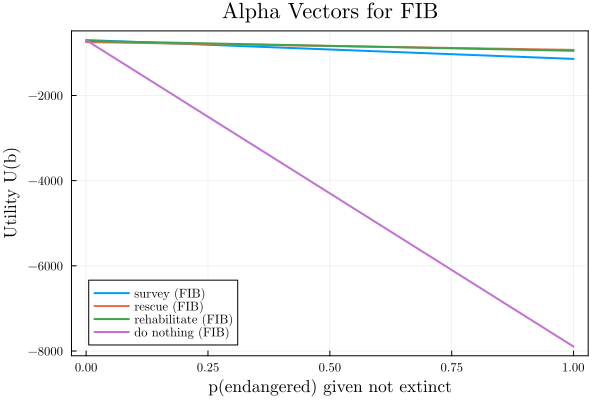

In [12]:
begin
	# Alpha Vectors for FIB, where extinct belief is 0
	
	default(fontfamily="Computer Modern", framestyle=:box) 
	p_extinct = 0
	
	#print(alphavectors(qmdp_policy))

	alpha_do_nothing_fib = alphavectors(fib_policy)[1]
	alpha_survey_fib = alphavectors(fib_policy)[2]
	alpha_rescue_fib = alphavectors(fib_policy)[3]
	alpha_rehabilitate_fib = alphavectors(fib_policy)[4]
	print(alphavectors(fib_policy))
	x_fib = range(0, 1, length=100)
	y1_fib = @.  (alpha_do_nothing_fib[2]-alpha_do_nothing_fib[3]) * x + alpha_do_nothing_fib[3]
	y2_fib = @. (alpha_survey_fib[2]-alpha_survey_fib[3]) *x + alpha_survey_fib[3]
	y3_fib = @.  (alpha_rescue_fib[2]-alpha_rescue_fib[3]) * x + alpha_rescue_fib[3]
	y4_fib = @. (alpha_rehabilitate_fib[2]-alpha_rehabilitate_fib[3]) *x + alpha_rehabilitate_fib[3]
	

	plot3 = plot(x_fib, [y2_fib y3_fib y4_fib y1_fib], title="Alpha Vectors for FIB", xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)", label=["survey (FIB)" "rescue (FIB)" "rehabilitate (FIB)" "do nothing (FIB)"], linewidth=2)
	#action(qmdp_policy, [1-p_endangered - p_threatened,p_endangered, p_threatened])
	#plot_alpha_vectors(qmdp_policy, p_hungry)
    
end

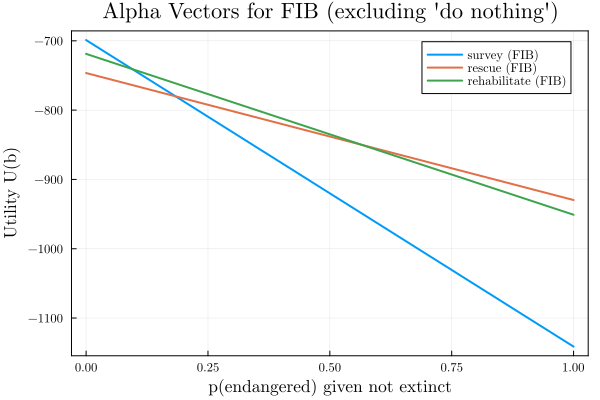

In [13]:
#simplified FIB plot

plot4 = plot(x_fib, [y2_fib y3_fib y4_fib], title="Alpha Vectors for FIB (excluding 'do nothing')", xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)", label=["survey (FIB)" "rescue (FIB)" "rehabilitate (FIB)"], linewidth=2)
	#action(qmdp_policy, [1-p_endangered - p_threatened,p_endangered, p_threatened])
	#plot_alpha_vectors(qmdp_policy, p_hungry)

In [14]:
bound1_1 = (alpha_survey[3]-alpha_rehabilitate[3])/(alpha_rehabilitate[2]-alpha_rehabilitate[3]-alpha_survey[2]+alpha_survey[3]) 
println(bound1_1)
bound2_1 = (alpha_rescue[3]-alpha_rehabilitate[3])/(alpha_rehabilitate[2]-alpha_rehabilitate[3]-alpha_rescue[2]+alpha_rescue[3]) 
println(bound2_1)
function optimal_qmdp(x)
    if x >= 0 && x < bound1_1 
        (alpha_survey[2]-alpha_survey[3]) *x + alpha_survey[3]
    elseif x >= bound1_1 && x < bound2_1
        (alpha_rehabilitate[2]-alpha_rehabilitate[3]) *x + alpha_rehabilitate[3] 
    else  
        (alpha_rescue[2]-alpha_rescue[3]) * x + alpha_rescue[3]
    end     
end




bound1_2 = (alpha_survey_fib[3]-alpha_rehabilitate_fib[3])/(alpha_rehabilitate_fib[2]-alpha_rehabilitate_fib[3]-alpha_survey_fib[2]+alpha_survey_fib[3]) 
println(bound1_2)
bound2_2 = (alpha_rescue_fib[3]-alpha_rehabilitate_fib[3])/(alpha_rehabilitate_fib[2]-alpha_rehabilitate_fib[3]-alpha_rescue_fib[2]+alpha_rescue_fib[3]) 
println(bound2_2)
function optimal_fib(x)
    if x >= 0 && x < bound1_2
        (alpha_survey_fib[2]-alpha_survey_fib[3]) *x + alpha_survey_fib[3]
    elseif x >= bound1_2 && x < bound2_2
        (alpha_rehabilitate_fib[2]-alpha_rehabilitate_fib[3]) *x + alpha_rehabilitate_fib[3] 
    else  
        (alpha_rescue_fib[2]-alpha_rescue_fib[3]) * x + alpha_rescue_fib[3]
    end     
end
#plot(x_fib, [y2_fib y3_fib y4_fib], title="Alpha Vectors for FIB", xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)", label=["survey (FIB)" "rescue (FIB)" "rehabilitate (FIB)"], linewidth=2)

plot5 = plot(x, [optimal_qmdp, optimal_qmdp1], title="Optimal Value Functions", 
    xlabel="p(endangered) given not extinct", ylabel = "Utility U(b)", linewidth=3, label = ["QMDP" "FIB"])

0.07127086700563182
0.5000010666006987
0.09474515810182055
0.5655844039096527


LoadError: UndefVarError: optimal_qmdp1 not defined

In [15]:
# Solve POMDP using partially observable upper confidence tree (PO-UCT) online tree search algorithm, a Monte Carlo method

pomcp_solver = POMCPSolver()
pomcp_planner = solve(pomcp_solver, pomdp);

# Visualize beginning of tree that is constructed
aₚ, info = action_info(pomcp_planner, initialstate(pomdp), tree_in_info=true); aₚ
tree = D3Tree(info[:tree], init_expand=2)

o: <root>
N: 1000      
├──a: do_nothing
│  N: 8      
│  V: -815      
│  └──o: seen_nothing
│     N: 7         
│     ├──a: do_nothing
│     │  N: 1      
│     │  V: -1.41e+03  (1 children)
│     ├──a: survey
│     │  N: 3      
│     │  V: -987       (2 children)
│     ├──a: rescue
│     │  N: 2      
│     │  V: -664       (1 children)
│     └──a: rehabilitate
│        N: 1      
│        V: -947       (1 children)
├──a: survey
│  N: 1      
│  V: -1.35e+03 
│  └──o: wild_living
│     N: 0         
│     ├──a: do_nothing
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: survey
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: rescue
│     │  N: 0      
│     │  V: 0          (0 children)
│     └──a: rehabilitate
│        N: 0      
│        V: 0          (0 children)
├──a: rescue
│  N: 1      
│  V: -892      
│  └──o: seen_nothing
│     N: 0         
│     ├──a: do_nothing
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: survey
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: rescue
│     │  N: 0      
│     │  V: 0          (0 children)
│     └──a: rehabilitate
│        N: 0      
│        V: 0          (0 children)
└──a: rehabilitate
   N: 990    
   V: -681      
   ├──o: seen_nothing
   │  N: 981       
   │  ├──a: do_nothing
   │  │  N: 902    
   │  │  V: -673       (3 children)
   │  ├──a: survey
   │  │  N: 76     
   │  │  V: -739       (3 children)
   │  ├──a: rescue
   │  │  N: 2      
   │  │  V: -826       (1 children)
   │  └──a: rehabilitate
   │     N: 1      
   │     V: -948       (1 children)
   ├──o: wild_carcass
   │  N: 0         
   │  ├──a: do_nothing
   │  │  N: 0      
   │  │  V: 0          (0 children)
   │  ├──a: survey
   │  │  N: 0      
   │  │  V: 0          (0 children)
   │  ├──a: rescue
   │  │  N: 0      
   │  │  V: 0          (0 children)
   │  └──a: rehabilitate
   │     N: 0      
   │     V: 0          (0 children)
   └──o: wild_living
      N: 6         
      ├──a: do_nothing
      │  N: 1      
      │  V: -561       (1 children)
      ├──a: survey
      │  N: 2      
      │  V: -624       (1 children)
      ├──a: rescue
      │  N: 2      
      │  V: -836       (1 children)
      └──a: rehabilitate
         N: 1      
         V: -528       (1 children)

In [16]:
# Step through decisions that were made through POMCP planner, through states, actions, and observations

for (s, a, o) in stepthrough(pomdp, pomcp_planner, "s,a,o", max_steps=10)
    println("State was $s,")
    println("action $a was taken,")
    println("and observation $o was received.\n")
end

State was threatened,
action rehabilitate was taken,
and observation seen_nothing was received.

State was threatened,
action do_nothing was taken,
and observation seen_nothing was received.

State was threatened,
action rehabilitate was taken,
and observation seen_nothing was received.

State was threatened,
action rehabilitate was taken,
and observation seen_nothing was received.

State was threatened,
action rescue was taken,
and observation seen_nothing was received.

State was threatened,
action do_nothing was taken,
and observation seen_nothing was received.

State was endangered,
action survey was taken,
and observation wild_carcass was received.

State was endangered,
action rescue was taken,
and observation seen_nothing was received.

State was endangered,
action rescue was taken,
and observation seen_nothing was received.

State was endangered,
action do_nothing was taken,
and observation seen_nothing was received.



In [17]:
savefig(plot1,"/Users/phalpha/Desktop/Stanford/winter_2023/project_ims/alpha_qmdp.png")
savefig(plot2, "/Users/phalpha/Desktop/Stanford/winter_2023/project_ims/alpha_qmdp_reduced.png")   
savefig(plot3, "/Users/phalpha/Desktop/Stanford/winter_2023/project_ims/alpha_fib.png")   
savefig(plot4, "/Users/phalpha/Desktop/Stanford/winter_2023/project_ims/alpha_fib_reduced.png")   
savefig(plot5, "/Users/phalpha/Desktop/Stanford/winter_2023/project_ims/optimal.png")   


LoadError: UndefVarError: plot5 not defined

In [18]:
# for ternary plots
action1 = []
action2 = []
action3 = []
action4 = []

for i in 0:100 
    # Inner For-loop
    for j in 0:100-i 
        b = [i/100, j/100, (100-i-j)/100]
        a = action(qmdp_policy, b)
        if true
            if a == do_nothing
                push!(action1, b)
            elseif a == survey
                 push!(action2, b)
            elseif a == rescue
                 push!(action3, b)
            elseif a == rehabilitate
                 push!(action4, b)
            end
        end
    end
end

#println(action4)


In [19]:
# Check action that QMDP policy takes for various belief states
action1_fib = []
action2_fib = []
action3_fib = []
action4_fib = []

for i in 0:100 
    # Inner For-loop
    for j in 0:100-i 
        b = [i/100, j/100, (100-i-j)/100]
        a = action(fib_policy, b)
        if true
            if a == do_nothing
                push!(action1, b)
            elseif a == survey
                 push!(action2, b)
            elseif a == rescue
                 push!(action3, b)
            elseif a == rehabilitate
                 push!(action4, b)
            end
        end
    end
end

#println(action4)
